<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/main/projects/ECoG/load_ECoG_joystick_track.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/projects/ECoG/load_ECoG_joystick_track.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

## Loading of Miller ECoG data of the joystick track task

includes some visualizations

In [4]:
# @title Install packages (`nilearn`, `nimare`. `duecredit`), import `matplotlib` and set defaults
# install packages to visualize brains and electrode locations
!pip install nilearn --quiet
!pip install nimare --quiet
!pip install duecredit --quiet


#@title Data retrieval
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))
from utils.utils import load_data
from utils.plot_utils import *


from matplotlib import rcParams
from matplotlib import pyplot as plt
import numpy as np


rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

## Load the data

In [10]:
# @title Data loading
alldat = load_data()
dat = alldat[0,0]
# Select just one of the recordings here. This is subject 1, block 1.
num_participants = alldat.shape[1]
print(dat.keys())

dict_keys(['V', 'targetX', 'targetY', 'cursorX', 'cursorY', 'locs', 'hemisphere', 'lobe', 'gyrus', 'Brodmann_Area'])


In [11]:
print(dat["V"].shape)

(372760, 60)


In [3]:
np.unique(dat["Brodmann_Area"])

array(['Brodmann area 10', 'Brodmann area 2', 'Brodmann area 21',
       'Brodmann area 22', 'Brodmann area 3', 'Brodmann area 38',
       'Brodmann area 4', 'Brodmann area 40', 'Brodmann area 42',
       'Brodmann area 43', 'Brodmann area 44', 'Brodmann area 45',
       'Brodmann area 46', 'Brodmann area 47', 'Brodmann area 6',
       'Brodmann area 8', 'Brodmann area 9'], dtype='<U16')

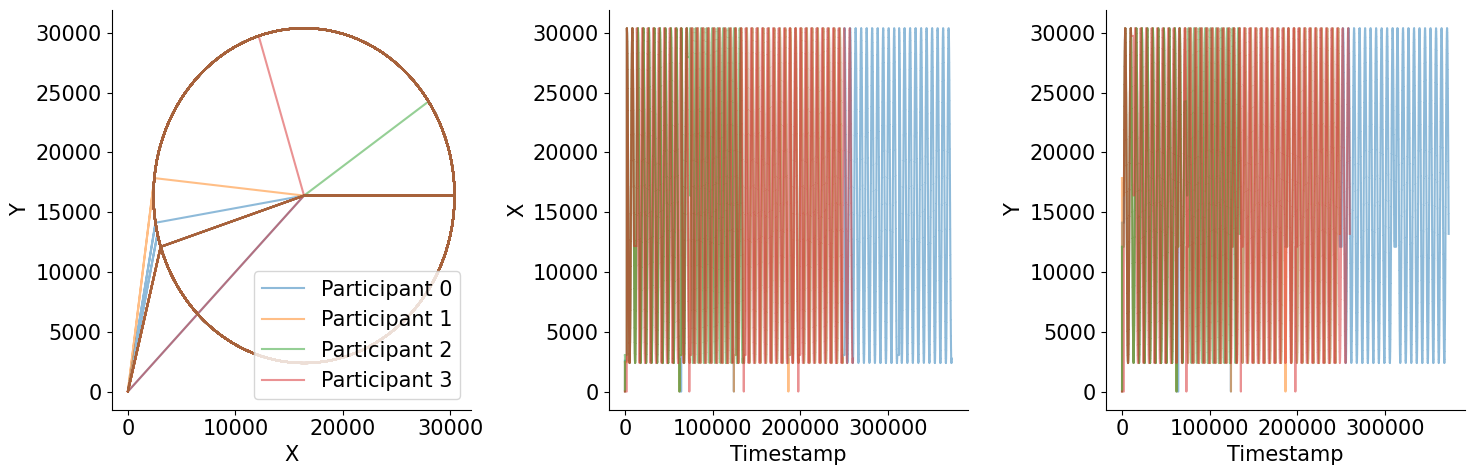

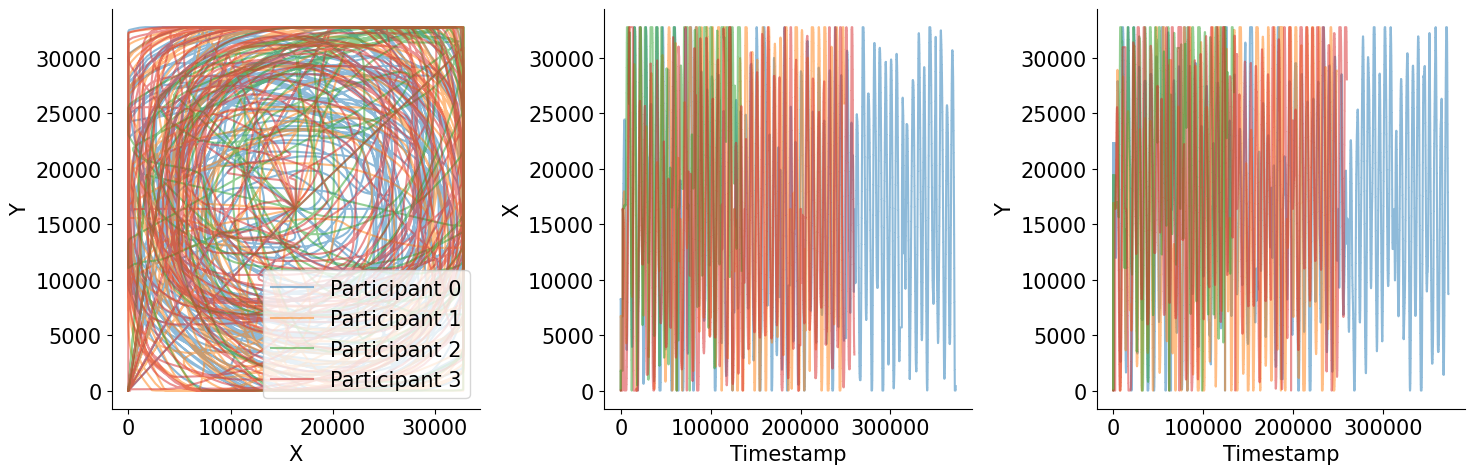

In [3]:
plot_target_cursors(alldat, alldat[0,2]["V"].shape[0])

In [ ]:
# Get rotation frequency of target cursor
intercepts = np.where(dat["targetY"] == 0)[0]
distances = np.roll(intercepts,-1) - intercepts
stationary = distances[np.where(distances == 1)]
distances = distances[np.where(distances > 1)]
total_time = distances[0] + np.sum(stationary)/3
print(total_time*2/2500)


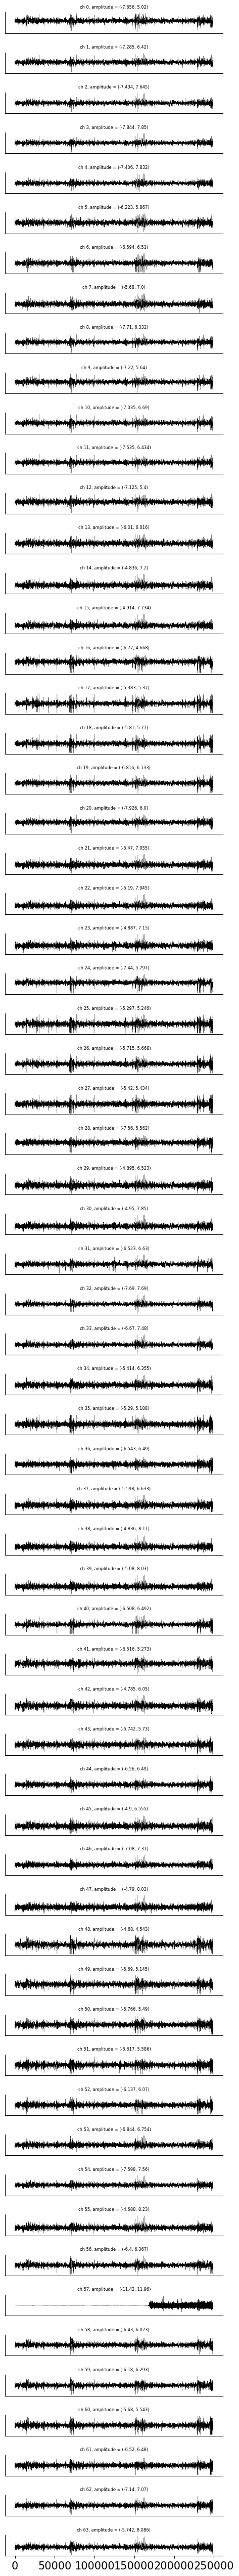

In [6]:
dat = alldat[0][1]
plot_signals(dat["V"])

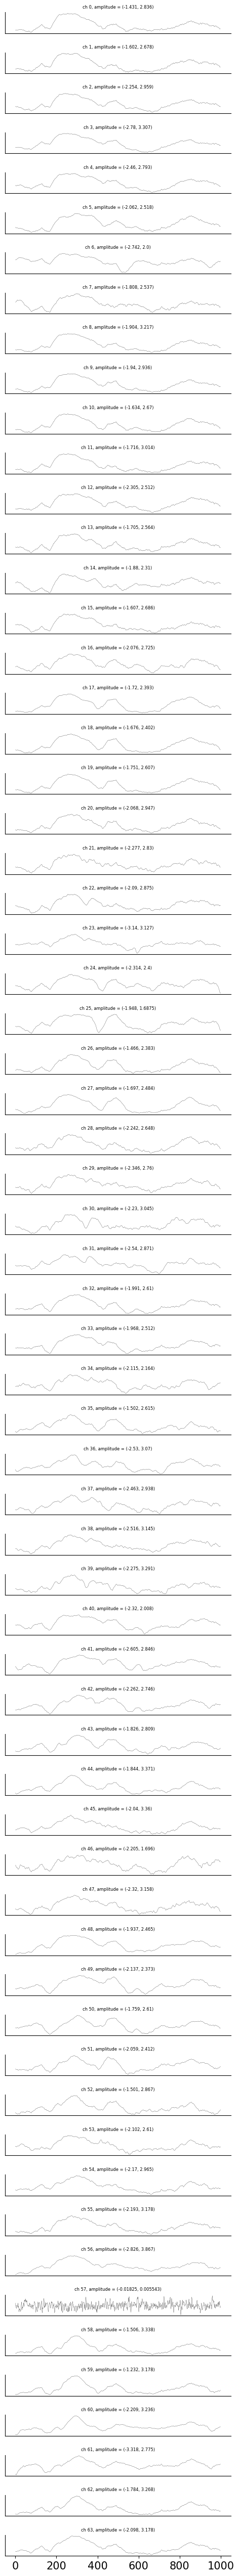

In [8]:
plot_signals(dat["V"], window=[1000,2000])

In [83]:
dict_subject = {"Timepoints" : [], "Electrodes" : []}
for i in range(num_participants):
    for key in alldat[0,i].keys():
        if key == "V":
            dict_subject["Timepoints"].append(alldat[0,i][key].shape[0])
            dict_subject["Electrodes"].append(alldat[0,i][key].shape[1])
dict_subject
import pandas as pd
df  = pd.DataFrame(dict_subject, index = [f"Participant {i}" for i in range(4)])
df

Timepoints  Electrodes
Participant 0      372760          60
Participant 1      248640          64
Participant 2      134360          64
Participant 3      259920          48

# Dataset info #

This is one of multiple ECoG datasets from Miller 2019, recorded in clinical settings with a variety of tasks. Raw data here:

https://exhibits.stanford.edu/data/catalog/zk881ps0522

`dat` contain 4 sessions from 4 subjects, and was used in these papers: 

- Schalk, G., et al. "Decoding two-dimensional movement trajectories using electrocorticographic signals in humans." Journal of Neural Engineering 4.3 (2007): 264. doi: [10.1088/1741-2560/4/3/012](https://doi.org/10.1088/1741-2560/4/3/012)

- Schalk, Gerwin, et al. "Two-dimensional movement control using electrocorticographic signals in humans." Journal of Neural Engineering 5.1 (2008): 75. doi: [10.1088/1741-2560/5/1/008](https://doi.org/10.1088/1741-2560/5/1/008)

<br>

From the dataset readme: 

*During the study, each patient was in a semi-recumbent position in a hospital bed about 1 m from a computer monitor. The patient used a joystick to maneuver a white cursor track a green target moving counter-clockwise in a circle of diameter 85% of monitor height ~1m away. The hand used to control the joystick was contralateral to the implanted electrode array.*

<br>

We also know that subject 0 was implanted in the left temporal lobe, while subject 2 was implanted in the right frontal lobe. 

Sample rate is always 1000Hz, and the ECoG data has been notch-filtered at 60, 120, 180, 240 and 250Hz, followed by z-scoring across the entire recording and conversion to float16 to minimize size. 

Variables are: 
* `dat['V']`: continuous voltage data (time by channels)
* `dat['targetX']`: position of the target on the screen
* `dat['targetY']`: position of the target on the screen
* `dat['cursorX']`: X position of the cursor controlled by the joystick 
* `dat['cursorY']`: X position of the cursor controlled by the joystick 
* `dat['locs`]: three-dimensional coordinates of the electrodes

In [5]:
from nilearn import plotting
from nimare import utils

plt.figure(figsize=(8, 8))
locs = dat['locs']
view = plotting.view_markers(utils.tal2mni(locs),
                             marker_labels=['%d'%k for k in np.arange(locs.shape[0])],
                             marker_color='purple',
                             marker_size=5)
view

<Figure size 800x800 with 0 Axes>

In [6]:
# compute correlations between voltage data and X/Y position of cursor
from scipy import signal
dat = alldat[0][3]

V = dat['V'].astype('float32')

nt, nchan = V.shape

targetX = dat['targetX'].flatten()
targetY = dat['targetY'].flatten()

cx = np.zeros(nchan, )
cy = np.zeros(nchan, )
for j in range(nchan):
  cx[j] = np.corrcoef(V[:, j], targetX)[0, 1]
  cy[j] = np.corrcoef(V[:, j], targetY)[0, 1]

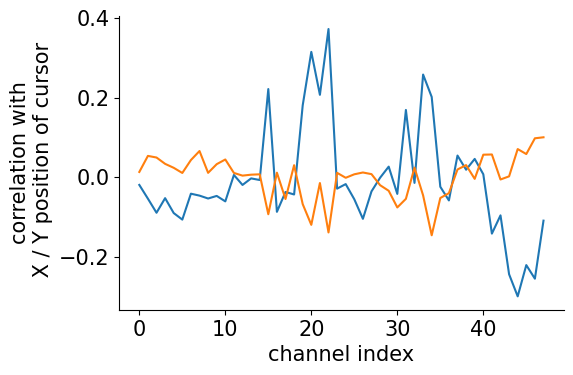

In [7]:
plt.subplot(1, 4, 1)
plt.plot(cx)
plt.plot(cy)
plt.ylabel('correlation with\n X / Y position of cursor')
plt.xlabel('channel index')
plt.show()